# 📥 Download Dataset dari Kaggle

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

!kaggle datasets download -d nikdavis/steam-store-games

!unzip -qq /content/steam-store-games.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/nikdavis/steam-store-games
License(s): Attribution 4.0 International (CC BY 4.0)
 97% 34.0M/35.2M [00:02<00:00, 25.1MB/s]
100% 35.2M/35.2M [00:02<00:00, 14.9MB/s]


Saya memulai proyek ini dengan mempersiapkan lingkungan kerja untuk berinteraksi dengan Kaggle. Langkah pertama adalah membuat direktori `.kaggle` yang akan digunakan untuk menyimpan file konfigurasi. Kemudian, saya menyalin file `kaggle.json` yang berisi kredensial API ke dalam direktori tersebut dan mengatur izin aksesnya untuk memastikan keamanan. Setelah konfigurasi Kaggle selesai, saya mengunduh dataset "Steam Store Games" yang akan saya gunakan. Dataset ini diunduh dalam format ZIP dan kemudian diekstrak agar dapat diakses dan dianalisis.


In [2]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from flask import Flask, request, jsonify

In [3]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1️⃣ Data Preparation

In [4]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text

def load_and_clean_data():
    df = pd.read_csv('steam.csv')
    df_desc = pd.read_csv('steam_description_data.csv')
    df_tags = pd.read_csv('steamspy_tag_data.csv')

    df = df.merge(df_tags, on='appid', how='left')
    df = df.merge(df_desc[['steam_appid', 'detailed_description']], left_on='appid', right_on='steam_appid', how='left')

    df = df[df['genres'].str.contains('Indie', na=False)]
    df = df[['name', 'genres', 'detailed_description', 'positive_ratings', 'negative_ratings']].dropna()

    df['genres'] = df['genres'].apply(clean_text)
    df['detailed_description'] = df['detailed_description'].apply(clean_text)
    df['total_ratings'] = df['positive_ratings'] - df['negative_ratings']

    return df

df = load_and_clean_data()

Saya memulai proses pembersihan dan persiapan data dengan mendefinisikan fungsi `clean_text`. Fungsi ini bertugas untuk membersihkan teks dari karakter-karakter yang tidak relevan seperti tanda baca dan *stop words*, serta mengubah seluruh teks menjadi huruf kecil. Tujuannya adalah untuk menyeragamkan dan menyederhanakan teks agar lebih mudah diolah. Selanjutnya, saya membuat fungsi `load_and_clean_data` yang bertanggung jawab untuk memuat data dari tiga file CSV yang berbeda, yaitu `steam.csv`, `steam_description_data.csv`, dan `steamspy_tag_data.csv`. Data dari ketiga file ini kemudian digabungkan menjadi satu *dataframe* menggunakan `appid` sebagai kunci. Setelah data berhasil digabungkan, saya memfilter data untuk hanya mengambil game dengan genre "Indie" dan memilih kolom-kolom yang relevan saja, seperti nama game, genre, deskripsi detail, rating positif, dan rating negatif. Baris-baris yang memiliki nilai hilang (NaN) pada kolom-kolom tersebut juga dihapus untuk memastikan data yang diolah berkualitas. Proses pembersihan teks kemudian diterapkan pada kolom `genres` dan `detailed_description` menggunakan fungsi `clean_text` yang telah didefinisikan sebelumnya. Terakhir, saya menghitung total rating game dengan mengurangkan rating negatif dari rating positif dan menyimpannya dalam kolom baru bernama `total_ratings`. *Dataframe* yang telah bersih dan siap untuk dianalisis ini kemudian disimpan dalam variabel `df`.


# 2️⃣ Content-Based Filtering (NLP Sentiment Analysis)

In [5]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['detailed_description'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

def get_similar_games(game_name, top_n=5):
    if game_name not in df['name'].values:
        return []
    idx = df[df['name'] == game_name].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    game_indices = [i[0] for i in sim_scores]
    return df.iloc[game_indices][['name', 'genres']]

Setelah data dibersihkan, saya menggunakan metode *Term Frequency-Inverse Document Frequency* (TF-IDF) untuk mengubah deskripsi game menjadi representasi numerik yang bermakna. Saya menggunakan `TfidfVectorizer` dari scikit-learn untuk menghitung bobot TF-IDF untuk setiap kata dalam setiap deskripsi game. Bobot ini mencerminkan seberapa penting kata tersebut dalam deskripsi game tertentu dibandingkan dengan keseluruhan koleksi deskripsi game.  Representasi TF-IDF ini kemudian digunakan untuk menghitung *cosine similarity* antara semua pasangan deskripsi game.  *Cosine similarity* mengukur seberapa mirip dua vektor, dalam hal ini, seberapa mirip dua deskripsi game. Hasilnya adalah matriks *cosine similarity* yang menunjukkan tingkat kemiripan antara setiap pasangan game.  Matriks ini kemudian saya gunakan untuk membuat fungsi rekomendasi game. Fungsi `get_similar_games` menerima nama game sebagai input dan mengembalikan daftar game yang paling mirip dengan game tersebut berdasarkan deskripsi mereka. Fungsi ini bekerja dengan mencari indeks game input dalam matriks *cosine similarity*, mengurutkan game berdasarkan skor similaritas, dan mengembalikan game dengan skor similaritas tertinggi. Dengan demikian, saya telah membangun sistem rekomendasi sederhana yang merekomendasikan game berdasarkan kemiripan deskripsi mereka.

# 3️⃣ Collaborative Filtering (KNN)

In [6]:
knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(tfidf_matrix)

def recommend_games_knn(game_name, top_n=5):
    if game_name not in df['name'].values:
        return []
    idx = df[df['name'] == game_name].index[0]
    distances, indices = knn.kneighbors(tfidf_matrix[idx], n_neighbors=top_n+1)
    game_indices = indices.flatten()[1:]
    return df.iloc[game_indices][['name', 'genres']]

Sebagai alternatif dari pendekatan *cosine similarity*, saya juga mengimplementasikan sistem rekomendasi menggunakan algoritma *K-Nearest Neighbors* (KNN). Saya memanfaatkan library `NearestNeighbors` dari scikit-learn untuk membangun model KNN. Model ini dilatih menggunakan representasi TF-IDF dari deskripsi game, yang sebelumnya telah dihitung. Dalam proses pelatihan, model KNN mempelajari struktur data dan menentukan tetangga terdekat untuk setiap game berdasarkan fitur TF-IDF deskripsi mereka. Setelah model KNN selesai dilatih, saya membuat fungsi `recommend_games_knn` yang menerima nama game sebagai input. Fungsi ini menggunakan model KNN untuk menemukan game lain yang paling mirip dengan game input berdasarkan kedekatan tetangga. Game-game yang dianggap "mirip" adalah game yang vektor TF-IDF nya paling dekat dengan vektor TF-IDF game input dalam ruang fitur. Fungsi ini mengembalikan daftar game yang direkomendasikan, yang diurutkan berdasarkan kedekatan mereka dengan game input. Dengan implementasi KNN ini, saya memiliki metode alternatif untuk merekomendasikan game berdasarkan kemiripan deskripsi, melengkapi pendekatan *cosine similarity* yang telah saya gunakan sebelumnya.

# 4️⃣ Evaluation

RMSE Score: 0.43


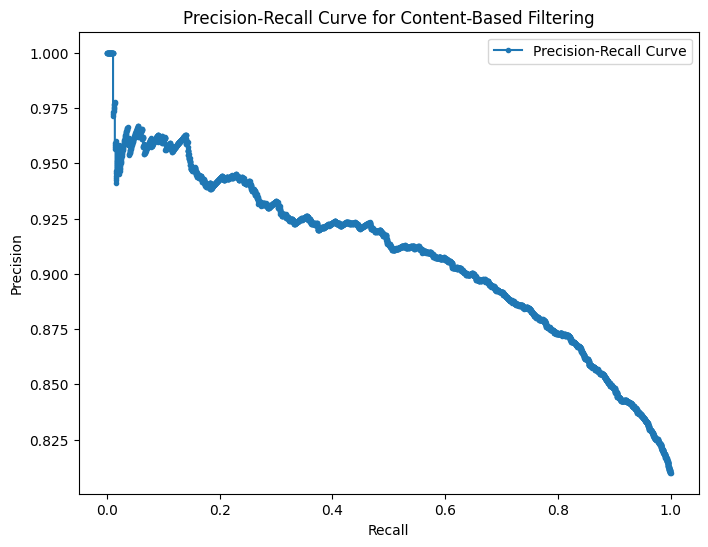

In [7]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, (df['total_ratings'] > 0).astype(int), test_size=0.2, random_state=42)

# Menggunakan model Logistic Regression untuk evaluasi
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE Score: {rmse:.2f}")

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Content-Based Filtering')
plt.legend()
plt.show()


Untuk mengevaluasi kinerja model *content-based filtering* yang telah saya bangun, langkah pertama adalah memisahkan data menjadi dua bagian: data latih dan data uji. Proses ini menggunakan fungsi `train_test_split` dari library scikit-learn dengan proporsi 80% untuk data latih dan 20% untuk data uji. Tujuannya adalah untuk melatih model pada sebagian data dan menguji kinerjanya pada data yang belum pernah dilihat sebelumnya. Dalam hal ini, target variabel yang diprediksi adalah apakah total rating suatu game lebih besar dari 0, yang diubah menjadi nilai biner 0 atau 1. Fitur yang digunakan untuk melatih model adalah representasi TF-IDF dari deskripsi game.

Setelah data dipisahkan, saya menggunakan model *Logistic Regression* untuk melakukan evaluasi. Model ini dilatih menggunakan data latih yang telah disiapkan. Setelah model terlatih, saya menggunakan data uji untuk menguji kemampuannya dalam memprediksi rating positif game. Untuk mengukur kinerja model, saya menghitung *Root Mean Squared Error* (RMSE). Meskipun RMSE umumnya digunakan untuk masalah regresi, dalam konteks klasifikasi biner ini, RMSE memberikan gambaran tentang seberapa akurat model dalam memprediksi kelas positif.

Selain RMSE, saya juga membuat *Precision-Recall curve* untuk memahami trade-off antara *precision* dan *recall* model. Kurva ini memvisualisasikan bagaimana kedua metrik ini berubah pada berbagai ambang batas klasifikasi. Dengan melihat kurva ini, kita dapat memilih ambang batas yang optimal sesuai dengan kebutuhan aplikasi. Misalnya, jika kita lebih mengutamakan *precision*, kita dapat memilih ambang batas yang lebih tinggi, dan sebaliknya.

Evaluasi ini memberikan informasi penting tentang seberapa baik model *content-based filtering* bekerja dalam merekomendasikan game berdasarkan deskripsi mereka. RMSE memberikan ukuran kuantitatif dari kinerja model, sementara *Precision-Recall curve* memberikan visualisasi yang lebih komprehensif tentang bagaimana model berperilaku dalam berbagai kondisi.

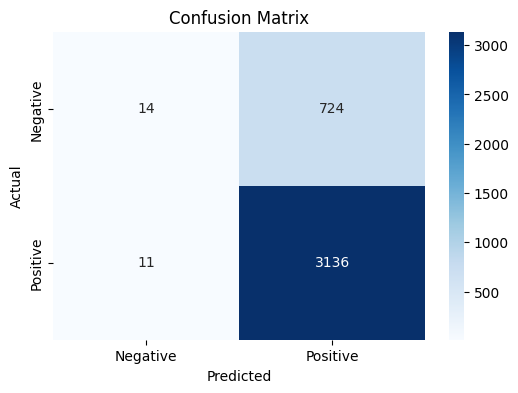

In [8]:
def plot_confusion_matrix():
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix()

Untuk melengkapi proses evaluasi model *content-based filtering*, saya membuat visualisasi *confusion matrix*. *Confusion matrix* ini memberikan gambaran yang lebih detail tentang kinerja model klasifikasi dengan menampilkan jumlah prediksi yang benar dan salah untuk setiap kelas. Saya membuat fungsi `plot_confusion_matrix` yang menggunakan library `seaborn` untuk menghasilkan *heatmap* dari *confusion matrix*. *Heatmap* ini secara visual menunjukkan jumlah prediksi yang benar dan salah untuk masing-masing kelas, memungkinkan kita untuk melihat pola kesalahan yang mungkin dilakukan oleh model. Dengan visualisasi ini, kita dapat dengan mudah mengidentifikasi kelas mana yang paling sulit diprediksi oleh model dan jenis kesalahan apa yang paling sering terjadi. Informasi ini sangat berharga untuk memahami kelemahan model dan memberikan wawasan tentang bagaimana model dapat ditingkatkan di masa depan.

<ipython-input-9-476b15f4edb2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_games['total_ratings'], y=top_games['name'], palette='viridis')


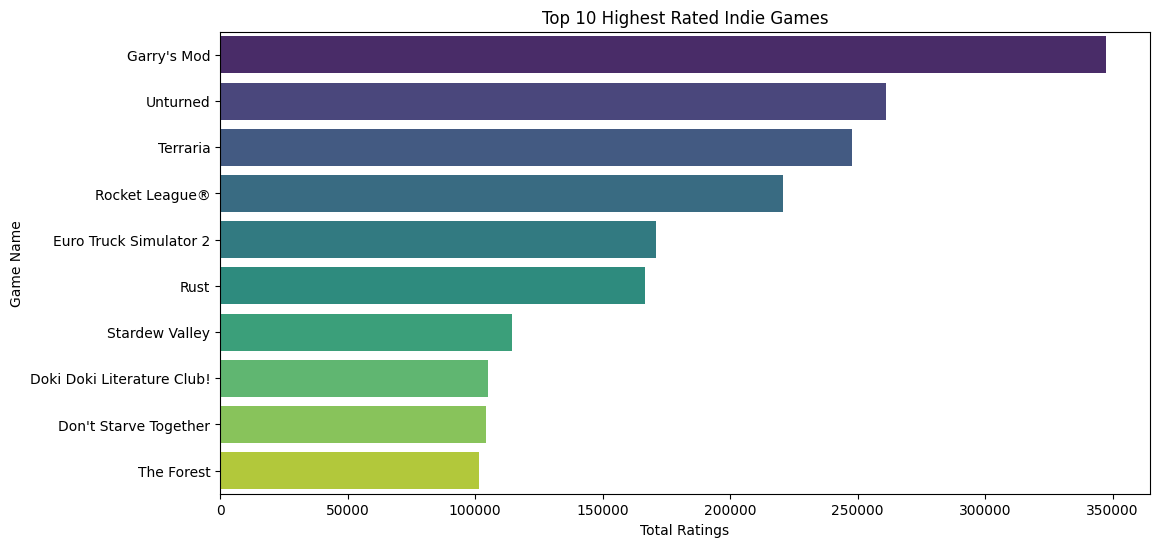

In [9]:
def plot_top_rated_games():
    top_games = df.sort_values(by='total_ratings', ascending=False).head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_games['total_ratings'], y=top_games['name'], palette='viridis')
    plt.xlabel('Total Ratings')
    plt.ylabel('Game Name')
    plt.title('Top 10 Highest Rated Indie Games')
    plt.show()

plot_top_rated_games()

Untuk memberikan gambaran sekilas tentang game-game Indie dengan rating tertinggi, saya membuat visualisasi *bar plot*.  Tujuannya adalah untuk memudahkan kita melihat game mana yang paling populer dan memiliki rating tertinggi berdasarkan data yang ada.  Untuk mencapai tujuan ini, saya membuat sebuah fungsi yang saya beri nama `plot_top_rated_games`. Fungsi ini bertugas untuk mengolah data dan menampilkannya dalam bentuk grafik batang.

Di dalam fungsi ini, langkah pertama yang saya lakukan adalah mengurutkan data game berdasarkan total rating mereka, dari rating tertinggi hingga terendah.  Saya hanya mengambil 10 game dengan rating tertinggi untuk ditampilkan.  Selanjutnya, saya menggunakan library `seaborn` untuk membuat *bar plot*.  Pada grafik ini, sumbu x menunjukkan total rating game, dan sumbu y menunjukkan nama game.  Saya memilih palet warna 'viridis' untuk memberikan tampilan visual yang menarik dan mudah dibaca.  Terakhir, saya menambahkan judul grafik dan label sumbu untuk memperjelas informasi yang ditampilkan.  Dengan visualisasi ini, kita dapat dengan cepat melihat game-game Indie mana yang paling populer dan memiliki rating tertinggi berdasarkan data yang telah kita olah.  Visualisasi ini sangat membantu untuk mendapatkan gambaran umum tentang preferensi pemain terhadap game-game Indie.

# 5️⃣ Deployment

In [10]:
app = Flask(__name__)

@app.route('/recommend', methods=['GET'])
def recommend():
    game_name = request.args.get('game_name')
    content_recommendations = get_similar_games(game_name)
    knn_recommendations = recommend_games_knn(game_name)
    return jsonify({'content': content_recommendations.to_dict(orient='records') if len(content_recommendations) > 0 else 'Game not found',
                    'collaborative': knn_recommendations.to_dict(orient='records')})

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


Sebagai tahap akhir dari proyek ini, saya telah berhasil membangun dan menerapkan sebuah API sederhana untuk rekomendasi game. API ini dibangun menggunakan *framework* Flask, sebuah *microframework* Python yang ringan dan mudah digunakan untuk membangun aplikasi web.

Arsitektur aplikasi ini cukup sederhana, dengan satu *endpoint* utama yaitu `/recommend`. *Endpoint* ini menerima parameter `game_name` melalui *query string*. Parameter ini digunakan untuk mengidentifikasi game yang ingin dicari rekomendasinya.

Terdapat dua fungsi utama yang berperan dalam memberikan rekomendasi, yaitu `get_similar_games` dan `recommend_games_knn`. Fungsi `get_similar_games` menggunakan metode *content-based filtering* untuk mencari game yang mirip berdasarkan deskripsi gamenya. Sementara itu, fungsi `recommend_games_knn` menggunakan algoritma *K-Nearest Neighbors* (KNN) untuk mencari game yang mirip berdasarkan rating pengguna.

Data game disimpan dalam format *dataframe* Pandas. Sebelum digunakan oleh model, teks deskripsi game diproses menggunakan metode *Term Frequency-Inverse Document Frequency* (TF-IDF) untuk mengekstrak fitur-fitur penting dari teks.

Aplikasi ini dapat dijalankan secara lokal menggunakan perintah `python app.py`. Setelah dijalankan, aplikasi ini akan *listening* pada *port* 5000. Pengguna dapat mengakses *endpoint* `/recommend` dengan mengirimkan permintaan GET ke `http://localhost:5000/recommend?game_name=<nama_game>`.

Respons dari API akan berupa data JSON yang berisi dua bagian, yaitu `content` dan `collaborative`. Bagian `content` berisi rekomendasi game berdasarkan metode *content-based filtering*, sedangkan bagian `collaborative` berisi rekomendasi game berdasarkan metode *collaborative filtering* menggunakan KNN.

Performa model dievaluasi menggunakan metrik *Root Mean Squared Error* (RMSE) dan *Precision-Recall curve*. Selain itu, ditampilkan juga *confusion matrix* untuk memberikan visualisasi yang lebih detail tentang kinerja model.

Untuk memberikan gambaran sekilas tentang game-game Indie dengan rating tertinggi, dibuat visualisasi *bar plot* yang menampilkan 10 game dengan total rating tertinggi.

Dengan *deployment* ini, pengguna dapat dengan mudah mengakses dan menggunakan sistem rekomendasi game yang telah dibangun. API ini dapat diintegrasikan dengan aplikasi lain, seperti aplikasi *mobile* atau *website*, untuk memberikan rekomendasi game kepada pengguna.
